# Load

In [1]:
devtools::load_all("~/public/SiyuanLuo/projects/clustering_metrics/ClusteringMetrics")

ℹ Loading ClusteringMetrics
Registered S3 method overwritten by 'e1071':
  method       from  
  print.fclust fclust



In [2]:
library(ggplot2)
library(tidyr)
library(cowplot)
library(dplyr)
library(grid)
library(ggtext)


Attaching package: ‘tidyr’


The following object is masked from ‘package:testthat’:

    matches



Attaching package: ‘dplyr’


The following object is masked from ‘package:testthat’:

    matches


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
fuzzy_true = TRUE
fuzzy_pred = FALSE
useMedianDist = TRUE

# Data
Simulate Visium-like hexagonal grid data

In [4]:
# Define the grid dimensions
n_rows <- 16
n_cols <- 15  

simulate_array <- function(n_rows=10, n_cols=10){
  # Create coordinates for the hexagonal grid
  array <- data.frame(row = integer(), col = integer())
  
  for (r in 0:(n_rows - 1)) {
    if (r %% 2 == 0) {
      # Even row: column indices are even (0, 2, 4, ...)
      cols <- seq(0, n_cols*2 - 1, by = 2)
    } else {
      # Odd row: column indices are odd (1, 3, 5, ...)
      cols <- seq(1, n_cols*2 - 1, by = 2)
    }
    # Add to coordinates data frame
    array <- rbind(array, data.frame(row = r, col = cols))
  }
  return(array)
}

simulate_hexagonal_grid <- function(n_rows=10, n_cols=10){
  hex_radius <- 1
  hex_height <- 1.5 * hex_radius
  
  # Initialize vectors to store the x and y coordinates
  x_coords <- numeric(n_rows * n_cols)
  y_coords <- numeric(n_rows * n_cols)
  
  index <- 1
  
  for (row in 1:n_rows) {
    for (col in 1:n_cols) {
      # Calculate x and y for the center of the hexagon
      x <- col * sqrt(3) * hex_radius
      y <- row * hex_height
      
      # Shift alternate rows
      if (row %% 2 == 0) {
        x <- x + sqrt(3)/2
      }
      
      # Store the coordinates
      x_coords[index] <- x
      y_coords[index] <- y
      index <- index + 1
    }
  }
  
  # Return the coordinates as a data frame
  coords <- data.frame(x = x_coords, y = y_coords)
  coords <- cbind(coords, simulate_array(n_rows, n_cols))
  return(coords)
}


data <- simulate_hexagonal_grid(n_rows, n_cols)
data$label <- NA
for (i in 1:dim(data)[1]) {
  if(data[i, "col"] > data[i, "row"] + 6){
    data[i, "label"] <- 1
  }else{
  data[i, "label"] <- 2
  }
}
data$label <- factor(data$label)

Simulate some errors

In [5]:
s <- 3
st <- 1

data$p2 <- data$label
data[data$row == 4 & (data$col %in% c(12,14,16,18,20)), "p2"] <- factor(2, levels=c(1,2))
data[data$row == 5 & (data$col %in% c(13,15,17,19)), "p2"] <- factor(2, levels=c(1,2))
data[data$row == 6 & (data$col %in% c(14,16,18,20)), "p2"] <- factor(2, levels=c(1,2))
data[data$row == 7 & (data$col %in% c(15,17,19)), "p2"] <- factor(2, levels=c(1,2))

data$p1 <- data$label
for (i in unique(data$row)) {
  data[data$row==i & data$col==i+8, "p1"] <- factor(2, levels=c(1,2))
} 

p0 <- ggplot(data, aes(x, y, 
               color=label)) + 
  geom_point(size=s, alpha=0.5) + scale_y_reverse() + theme_bw() +
  geom_point(shape = 1, size = s, stroke = st, aes(color=label)) + 
  labs(x="",y="", title="C") 


p1 <- ggplot(data, aes(x, y, 
               color=label)) + 
  geom_point(size=s, alpha=0.5) + scale_y_reverse() + theme_bw() +
  geom_point(shape = 1, size = s, stroke = st, aes(color=p1)) + 
  labs(x="",y="", title="P1") 


p2 <- ggplot(data, aes(x, y, 
               color=label)) + 
  geom_point(size=s, alpha=0.5) + scale_y_reverse() + theme_bw() +
  geom_point(shape = 1, size = s, stroke = st, aes(color=p2)) + 
  labs(x="",y="", title="P2") 

In [6]:
data$p3 <- data$label
data[data$row == 3 & (data$col %in% c(21,23)), "p3"] <- factor(2, levels=c(1,2))

data[data$row == 4 & (data$col %in% c(12,14)), "p3"] <- factor(2, levels=c(1,2))
data[data$row == 5 & (data$col %in% c(13,15)), "p3"] <- factor(2, levels=c(1,2))

data[data$row == 6 & (data$col %in% c(18)), "p3"] <- factor(2, levels=c(1,2))

data[data$row == 5 & (data$col %in% c(21,23)), "p3"] <- factor(2, levels=c(1,2))
data[data$row == 6 & (data$col %in% c(22)), "p3"] <- factor(2, levels=c(1,2))

data[data$row == 9 & (data$col %in% c(25)), "p3"] <- factor(2, levels=c(1,2))

data[data$row == 12 & (data$col %in% c(22,26)), "p3"] <- factor(2, levels=c(1,2))

data[data$row == 10 & (data$col %in% c(18,20)), "p3"] <- factor(2, levels=c(1,2))
data[data$row == 11 & (data$col %in% c(19)), "p3"] <- factor(2, levels=c(1,2))

p3 <- ggplot(data, aes(x, y, 
               color=label)) + 
  geom_point(size=s, alpha=0.5) + scale_y_reverse() + theme_bw() +
  geom_point(shape = 1, size = s, stroke = st, aes(color=p3)) + 
  labs(x="",y="", title="P3") 

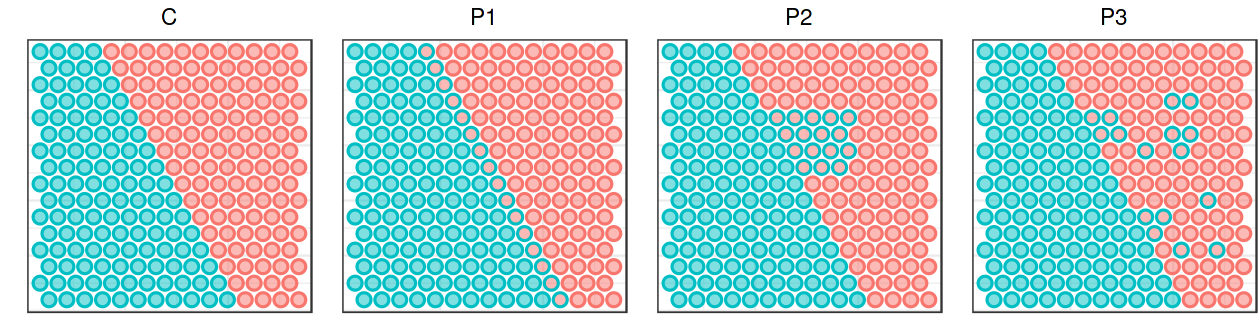

In [7]:
options(repr.plot.width=10.5, repr.plot.height=2.8)
# grDevices::cairo_pdf("Fig1.pdf", width=10, height=3)
ps1 <- plot_grid(
    p0 + theme(legend.position = "none", plot.title = element_text(hjust = 0.5), plot.margin = margin(5, 2, -2, 0), 
    axis.text.x = element_blank(), axis.text.y = element_blank(),axis.ticks.x = element_blank(), axis.ticks.y = element_blank()),
    p1 + theme(legend.position = "none", plot.title = element_text(hjust = 0.5), plot.margin = margin(5, 2, -2, 0),
    axis.text.x = element_blank(), axis.text.y = element_blank(),axis.ticks.x = element_blank(), axis.ticks.y = element_blank()), 
    p2 + theme(legend.position = "none", plot.title = element_text(hjust = 0.5), plot.margin = margin(5, 2, -2, 0),
    axis.text.x = element_blank(), axis.text.y = element_blank(),axis.ticks.x = element_blank(), axis.ticks.y = element_blank()), 
    p3 + theme(legend.position = "none", plot.title = element_text(hjust = 0.5), plot.margin = margin(5, 2, -2, 0),
    axis.text.x = element_blank(), axis.text.y = element_blank(),axis.ticks.x = element_blank(), axis.ticks.y = element_blank()),
    ncol = 4)
plot(ps1)
# dev.off()


# Dataset-level metrics

In [8]:
head(data)

,x,y,row,col,label,p2,p1,p3
,<dbl>,<dbl>,<int>,<dbl>,<fct>,<fct>,<fct>,<fct>
1,1.732051,1.5,0,0,2,2,2,2
2,3.464102,1.5,0,2,2,2,2,2
3,5.196152,1.5,0,4,2,2,2,2
4,6.928203,1.5,0,6,2,2,2,2
5,8.660254,1.5,0,8,1,1,2,1
6,10.392305,1.5,0,10,1,1,1,1


In [9]:
k <- 6
pred <- c("p1","p2","p3")
pred_name <- c("P1","P2","P3")
label <- data$label
location <- data[, c('x','y')]
internal <-lapply(setNames(c("label","p1","p2","p3"), c("C","P1","P2","P3")), function(x){getSpatialGlobalInternalMetrics(data[[x]], location, k=k, metrics=c("PAS", "ELSA", "CHAOS","MPC", "PC", "PE"))})
internal <- bind_rows(internal,.id = "prediction")
externalSpatial <- lapply(setNames(pred, pred_name), function(x){getSpatialGlobalExternalMetrics(label, data[[x]], location=location, fuzzy_true=fuzzy_true, fuzzy_pred=fuzzy_pred, k=k, 
                                                                                                 metrics=c("SpatialRI","SpatialARI","SpatialWH","SpatialAWH", "SpatialWC","SpatialAWC","SpatialAccuracy","setMatchingAccuracy"),
                                                                                                 useMedianDist=useMedianDist)})
externalSpatial <- bind_rows(externalSpatial, .id = "prediction")                                                                                                

externalNormal <- lapply(setNames(pred, pred_name), function(x){getPartitionGlobalMetrics(label, data[[x]], metrics=c("RI","WC","WH","ARI","AWC","AWH"))})
externalNormal <- bind_rows(externalNormal, .id = "prediction")

Comparing between a fuzzy truth and a hard prediction...

Standard error of the mean NDC across permutations:0.00105

Comparing between a fuzzy truth and a hard prediction...

Standard error of the mean NDC across permutations:0.000617

Comparing between a fuzzy truth and a hard prediction...

Standard error of the mean NDC across permutations:0.000591



In [10]:
internal

prediction,PAS,ELSA.Ea,ELSA.Ec,ELSA,CHAOS,MPC,PC,PE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
C,0.008333333,0.07012866,0.1942331,0.05940498,0.2305866,0.9239985,0.9619992,0.06112804
P1,0.004166667,0.07198272,0.1972541,0.06166950,0.2305866,0.9231340,0.9615670,0.06244962
P2,0.016666667,0.09483870,0.2544137,0.07990288,0.2305866,0.8939059,0.9469529,0.08536578
P3,0.066666667,0.14846514,0.3524404,0.11597246,0.2349369,0.8114095,0.9057048,0.15122428


In [11]:
externalSpatial

prediction,SpatialRI,SpatialARI,SpatialWH,SpatialAWH,SpatialWC,SpatialAWC,SpatialAccuracy,setMatchingAccuracy
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
P1,0.8976987,0.7860482,0.8932535,0.7770412,0.9031979,0.7953291,0.9559028,0.9333333
P2,0.8823454,0.7543501,0.8763988,0.7423614,0.8895191,0.7667125,0.9388889,0.9333333
P3,0.8823454,0.7546937,0.8763988,0.7427198,0.8895191,0.7670407,0.9388889,0.9333333


In [12]:
externalNormal

prediction,RI,WC,WH,ARI,AWC,AWH
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
P1,0.8750349,0.8834734,0.8679141,0.750084,0.7637173,0.736929
P2,0.8750349,0.8834734,0.8679141,0.750084,0.7637173,0.736929
P3,0.8750349,0.8834734,0.8679141,0.750084,0.7637173,0.736929


In [13]:
internal <- pivot_longer(internal, cols=-c("prediction"), names_to = "metric", values_to = "value")
dfc <- internal %>% filter(prediction == "C")
internal <- internal %>% filter(prediction != "C")
internal <- merge(internal, dfc, by.x = c("metric"), by.y = c("metric")) %>% select(-prediction.y) %>% rename(C = value.y) %>% rename(prediction = prediction.x) %>% rename(value = value.x) 
head(internal)


,metric,prediction,value,C
,<chr>,<chr>,<dbl>,<dbl>
1,CHAOS,P1,0.23058662,0.23058662
2,CHAOS,P2,0.23058662,0.23058662
3,CHAOS,P3,0.23493692,0.23058662
4,ELSA,P1,0.06166950,0.05940498
5,ELSA,P2,0.07990288,0.05940498
6,ELSA,P3,0.11597246,0.05940498


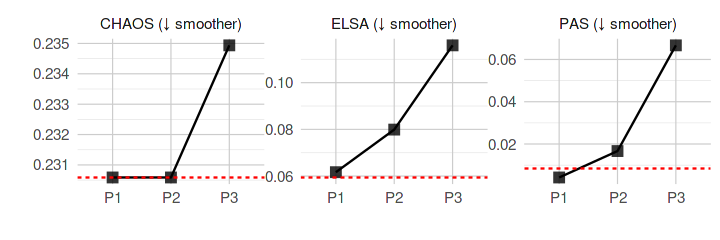

In [14]:
options(repr.plot.width=6, repr.plot.height=2)
pi <- internal %>% 
filter(metric %in% c("PAS", "ELSA", "CHAOS")) %>%
# filter(prediction %in% c('P1','P2')) %>%
ggplot(aes(x=prediction, y=value)) +
geom_point(size=3, alpha=0.8, shape=15) +
geom_line(aes(group=metric)) +
facet_wrap(~metric, scales = "free", nrow=1,
            labeller = as_labeller(c("PAS" = "PAS (↓ smoother)",
                                     "ELSA" = "ELSA (↓ smoother)",
                                     "CHAOS" = "CHAOS (↓ smoother)"))) +
geom_hline(aes(yintercept = C), linetype = "dashed", color = "red") +
theme_minimal() +
theme(legend.margin = margin(t = -5, r = 0, b = 0, l = 0, unit = "pt"),
    panel.spacing.x = unit(0, "cm")
    ) +  # Adjust the space between panels) +
theme(legend.position = "bottom", legend.key.height = unit(0.3, "cm"),
    panel.grid.major = element_line(linewidth = 0.25, color = "grey80"),
    panel.grid.minor = element_line(linewidth = 0.15, color = "grey90")) +
labs(y="", x="") 
pi

In [15]:
external <- merge(externalSpatial, externalNormal, by="prediction")
external <- pivot_longer(external, cols=-c("prediction"), names_to = "metric", values_to = "value")
external$metric_class <- sub("Spatial", "", external$metric)
external$metric_type <- ifelse(grepl("Spatial",external$metric) , "Spatial", "NonSpatial")
external <- data.frame(external)
external[external$metric=="SpatialAccuracy", "metric_class"] <- "Set Matching\nAccuracy"
external[external$metric=="setMatchingAccuracy", "metric_class"] <- "Set Matching\nAccuracy"

In [16]:
unique(external$metric_class)

[1] "RI"                     "ARI"                    "WH"                    
[4] "AWH"                    "WC"                     "AWC"                   
[7] "Set Matching\nAccuracy"

In [17]:
external$metric_class <- factor(external$metric_class, levels=c('RI','ARI','WH','AWH','WC','AWC','Set Matching\nAccuracy'))


Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


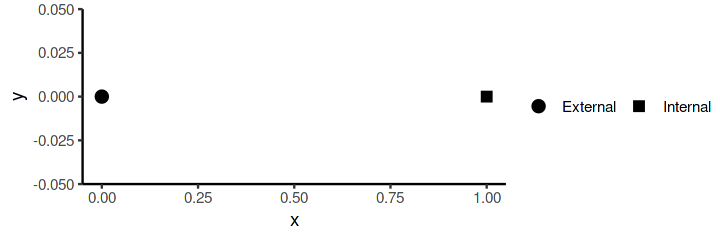

In [18]:
plot_with_legend <- ggplot(data.frame(type=c("External","Internal"), x=c(0,1)), aes(x = x, y = 0, shape = type)) +
  geom_point(size=3) +
  scale_shape_manual(values = c(19, 15)) + labs(shape="") +
  theme_classic() +
  guides(shape = guide_legend(nrow = 1)) +
  theme(legend.margin = margin(t = -5, r = 0, b = 0, l = 0, unit = "pt")) 
  
legend <- get_legend(plot_with_legend)
plot_with_legend

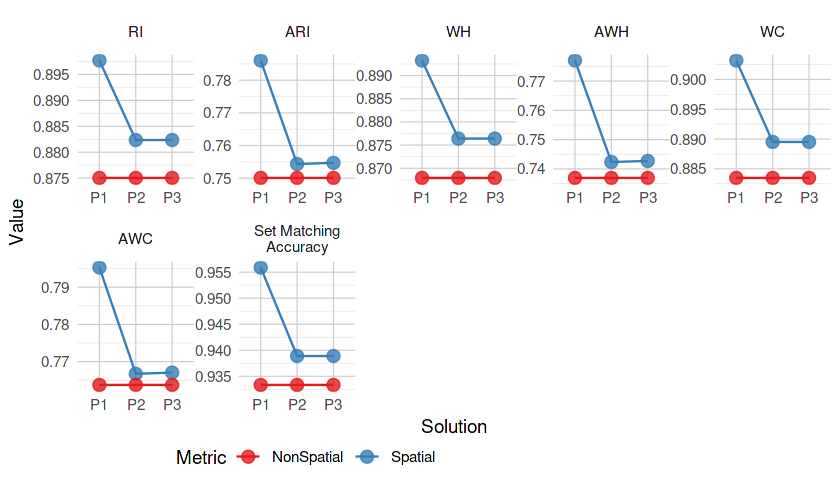

In [19]:
options(repr.plot.width=7, repr.plot.height=4)
pxx <- external %>% 
ggplot(aes(x=prediction, y=value, color=metric_type)) +
geom_point(size=3, alpha=0.8) +
geom_line(aes(group=metric)) +
facet_wrap(~metric_class, scales = "free", ncol=5) +
theme_minimal() +
theme(legend.margin = margin(t = -5, r = 0, b = 3, l = 0, unit = "pt"),
    panel.spacing.x = unit(0, "cm")) +  # Adjust the space between panels) +
theme(legend.position = "bottom", legend.justification = c(0.2, 0), legend.key.height = unit(0.3, "cm"),
    panel.grid.major = element_line(linewidth = 0.25, color = "grey80"),
    panel.grid.minor = element_line(linewidth = 0.15, color = "grey90")) +
labs(y="Value", x="Solution", color="Metric")  +
scale_color_brewer(palette = "Set1")
# ylim(0.7, 0.96)
pxx

In [20]:
px <- ggdraw() +
  draw_plot(pxx + theme(plot.margin = margin(0, 2, 2, 2))) +  # Main plot
  draw_plot(legend, x = 0.4, y = -0.18, width = 0.6, height = 0.48)  # Inset plot


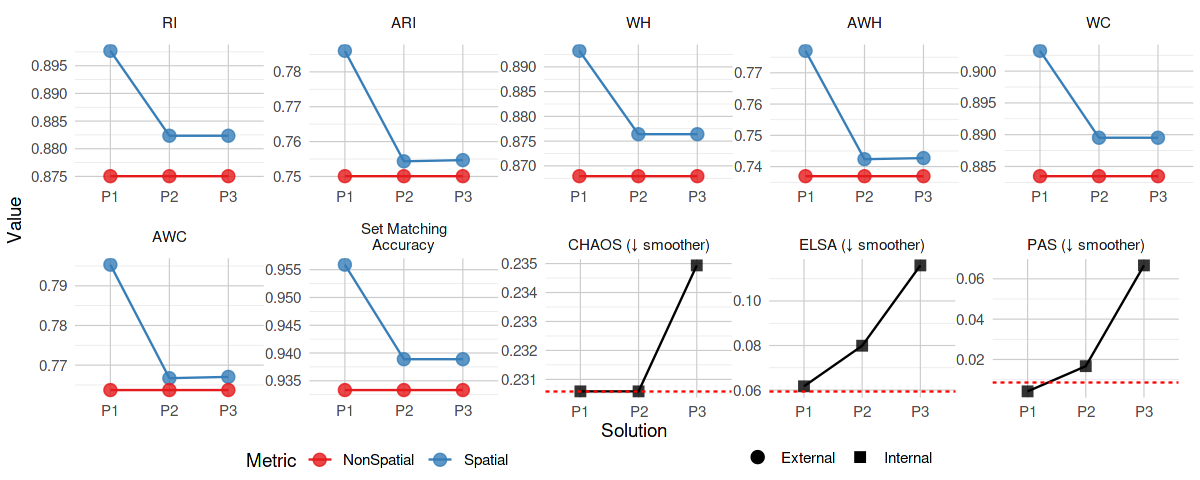

In [21]:
options(repr.plot.width=10, repr.plot.height=4)
p12 <- ggdraw() +
  draw_plot(px + theme(plot.margin = margin(0, 2, 2, 2))) +  # Main plot
  draw_plot(pi, x = 0.39, y = 0.059, width = 0.6, height = 0.48)  # Inset plot

p12

In [22]:
# grDevices::cairo_pdf("spatial_toy.pdf", width=10.5, height=6.8)
# plot_grid(ps1 + theme(legend.position = "None"), 
#           p12 + theme(legend.position = "None"), 
# labels = c("a", "b"), 
# label_size = 18,
# ncol = 1, rel_heights = c(2.8,4))
# dev.off()

# Class metrics

In [23]:
externalSpatialClass <- do.call(rbind, lapply(setNames(pred, pred_name), function(x){as.data.frame(getSpatialClassExternalMetrics(label, data[[x]], location=location, fuzzy_true=fuzzy_true, fuzzy_pred=fuzzy_pred, k=k, metrics=c("SpatialWH","SpatialAWH", 
                                                     "SpatialWC","SpatialAWC")))}))
externalSpatialClass$prediction <- sapply(strsplit(rownames(externalSpatialClass), "\\."), function(x){x[1]})
dfl <- externalSpatialClass %>% pivot_longer(cols = c("SpatialWH","SpatialAWH", "SpatialWC","SpatialAWC"), names_to = "metric", values_to = "value")
dfl$metric <- factor(dfl$metric, levels=c("SpatialWH","SpatialAWH", "SpatialWC","SpatialAWC"))

Comparing between a fuzzy truth and a hard prediction...



Standard error of the mean NDC across permutations:0.000746

Comparing between a fuzzy truth and a hard prediction...

Standard error of the mean NDC across permutations:0.00133

Comparing between a fuzzy truth and a hard prediction...

Standard error of the mean NDC across permutations:0.000207



In [24]:
df1 <- dfl %>% filter(metric %in% c("SpatialWH","SpatialAWH")) %>% select(-class) %>%  drop_na() %>% rename(class = cluster)
df2 <- dfl %>% filter(metric %in% c("SpatialWC","SpatialAWC")) %>% select(-cluster) %>%  drop_na() 
df1 <- as.data.frame(df1)
df2 <- as.data.frame(df2)
dfl <- rbind(df1,df2)
dfl$class <- factor(dfl$class, levels=c(1,2))

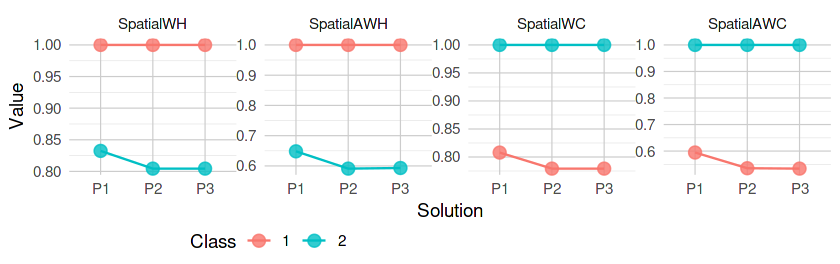

In [25]:
options(repr.plot.width=7, repr.plot.height=2.2)
pclass1 <- dfl %>% filter(prediction %in% c("P1", "P2", "P3")) %>%
ggplot(aes(x=prediction, y=value, color=class)) +
geom_point(size=3, alpha=0.8) +
geom_line(aes(group=class)) +
facet_wrap(~metric, scales = "free", ncol=5) +
theme_minimal() +
theme(legend.margin = margin(t = -5, r = 0, b = 3, l = 0, unit = "pt"),
    panel.spacing.x = unit(0, "cm")) +  # Adjust the space between panels) +
theme(legend.position = "bottom", legend.justification = c(0.2, 0), legend.key.height = unit(0.3, "cm"),
    panel.grid.major = element_line(linewidth = 0.25, color = "grey80"),
    panel.grid.minor = element_line(linewidth = 0.15, color = "grey90")) +
labs(y="Value", x="Solution", color="Class") +
# scale_color_brewer(palette = "Set1") +
scale_y_continuous(breaks=scales::pretty_breaks())
# ylim(0.7, 0.96)
pclass1

# P4, P5

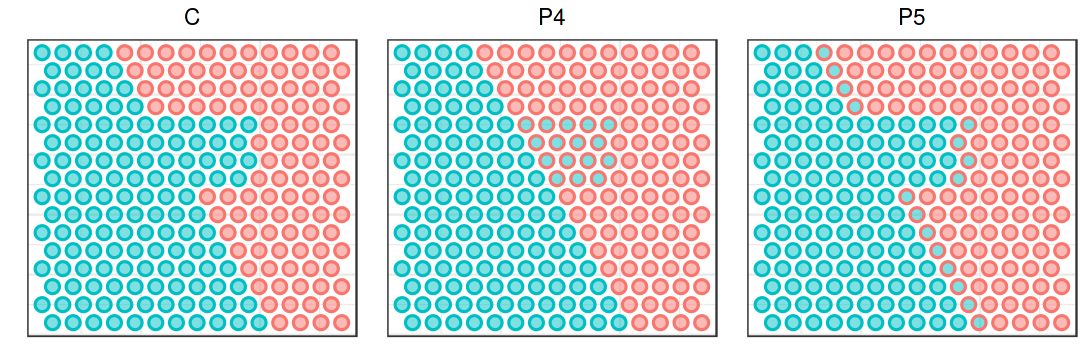

In [26]:
s <- 3
st <- 1

data$c2 <- data$p2
data$p4 <- data$label


data$p5 <- data$p2
data[data$row == 4 & (data$col %in% c(20)), "p5"] <- factor(1, levels=c(1,2))
data[data$row == 5 & (data$col %in% c(19)), "p5"] <- factor(1, levels=c(1,2))
data[data$row == 6 & (data$col %in% c(20)), "p5"] <- factor(1, levels=c(1,2))
data[data$row == 7 & (data$col %in% c(19)), "p5"] <- factor(1, levels=c(1,2))

for (i in unique(data$row)) {
  if(i !=4 & i!=5 & i!=6 & i!=7){
    data[data$row==i & data$col==i+6, "p5"] <- factor(1, levels=c(1,2))
  }
} 

pc <- ggplot(data, aes(x, y, 
               color=c2)) + 
  geom_point(size=s, alpha=0.5) + scale_y_reverse() + theme_bw() +
  geom_point(shape = 1, size = s, stroke = st, aes(color=c2)) + 
  labs(x="",y="", title="C") 


p4 <- ggplot(data, aes(x, y, 
               color=c2)) + 
  geom_point(size=s, alpha=0.5) + scale_y_reverse() + theme_bw() +
  geom_point(shape = 1, size = s, stroke = st, aes(color=p4)) + 
  labs(x="",y="", title="P4") 


p5 <- ggplot(data, aes(x, y, 
               color=c2)) + 
  geom_point(size=s, alpha=0.5) + scale_y_reverse() + theme_bw() +
  geom_point(shape = 1, size = s, stroke = st, aes(color=p5)) + 
  labs(x="",y="", title="P5") 

options(repr.plot.width=9, repr.plot.height=3)
# grDevices::cairo_pdf("Fig1.pdf", width=10, height=3)
ps3 <- plot_grid(pc + theme(legend.position = "none",plot.title = element_text(hjust = 0.5), plot.margin = margin(5, 2, -2, 0),
                            axis.text.x = element_blank(), axis.text.y = element_blank(),axis.ticks.x = element_blank(), axis.ticks.y = element_blank()),
                 p4 + theme(legend.position = "none",plot.title = element_text(hjust = 0.5), plot.margin = margin(5, 2, -2, 0),
                            axis.text.x = element_blank(), axis.text.y = element_blank(),axis.ticks.x = element_blank(), axis.ticks.y = element_blank()), 
                p5 + theme(legend.position = "none",plot.title = element_text(hjust = 0.5), plot.margin = margin(5, 2, -2, 0),
                            axis.text.x = element_blank(), axis.text.y = element_blank(),axis.ticks.x = element_blank(), axis.ticks.y = element_blank()), 
                # p3 + theme(legend.position = "none"), 
                # p4 + theme(legend.position = "none"), 
                # labels = c("C", "P1", "P2"), 
                ncol = 3)
plot(ps3)
# dev.off()


In [27]:
k <- 6
pred <- c("p4","p5")
pred_name <- c("P4","P5")
label <- data$c2
location <- data[, c('x','y')]
internal <-lapply(setNames(c("c2","p4","p5"), c("C","P4","P5")), function(x){getSpatialGlobalInternalMetrics(data[[x]], location, k=k, metrics=c("PAS", "ELSA", "CHAOS","MPC", "PC", "PE"))})
internal <- bind_rows(internal,.id = "prediction")
externalSpatial <- lapply(setNames(pred, pred_name), function(x){getSpatialGlobalExternalMetrics(label, data[[x]], location=location, fuzzy_true=fuzzy_true, fuzzy_pred=fuzzy_pred, k=k, 
                                                                                                 metrics=c("SpatialRI","SpatialARI","SpatialWH","SpatialAWH", "SpatialWC","SpatialAWC","SpatialAccuracy","setMatchingAccuracy"),
                                                                                                useMedianDist=useMedianDist)})
externalSpatial <- bind_rows(externalSpatial, .id = "prediction")                                                                                                
externalNormal <- lapply(setNames(pred, pred_name), function(x){getPartitionGlobalMetrics(label, data[[x]], metrics=c("RI","WC","WH","ARI","AWC","AWH"))})
externalNormal <- bind_rows(externalNormal, .id = "prediction")

Comparing between a fuzzy truth and a hard prediction...

Standard error of the mean NDC across permutations:0.00077

Comparing between a fuzzy truth and a hard prediction...

Standard error of the mean NDC across permutations:0.00112



In [28]:
internal <- pivot_longer(internal, cols=-c("prediction"), names_to = "metric", values_to = "value")
dfc <- internal %>% filter(prediction == "C")
internal <- internal %>% filter(prediction != "C")
internal <- merge(internal, dfc, by.x = c("metric"), by.y = c("metric")) %>% select(-prediction.y) %>% rename(C = value.y) %>% rename(prediction = prediction.x) %>% rename(value = value.x) 
head(internal)

,metric,prediction,value,C
,<chr>,<chr>,<dbl>,<dbl>
1,CHAOS,P4,0.23058662,0.23058662
2,CHAOS,P5,0.23058662,0.23058662
3,ELSA,P4,0.05940498,0.07990288
4,ELSA,P5,0.08638076,0.07990288
5,ELSA.Ea,P4,0.07012866,0.09483870
6,ELSA.Ea,P5,0.10071637,0.09483870


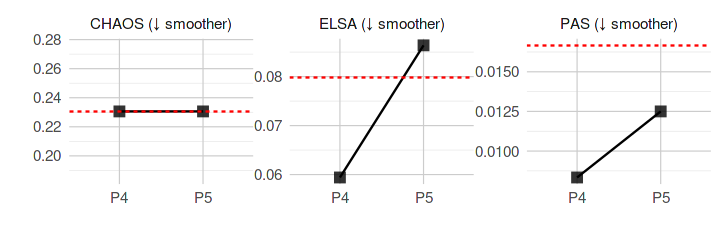

In [29]:
options(repr.plot.width=6, repr.plot.height=2)
pi <- internal %>% 
filter(metric %in% c("PAS", "ELSA", "CHAOS")) %>%
ggplot(aes(x=prediction, y=value)) +
geom_point(size=3, alpha=0.8, shape=15) +
geom_line(aes(group=metric)) +
facet_wrap(~metric, scales = "free", nrow=1,
            labeller = as_labeller(c("PAS" = "PAS (↓ smoother)",
                                     "ELSA" = "ELSA (↓ smoother)",
                                     "CHAOS" = "CHAOS (↓ smoother)"))) +
geom_hline(aes(yintercept = C), linetype = "dashed", color = "red") +
theme_minimal() +
theme(legend.margin = margin(t = -5, r = 0, b = 0, l = 0, unit = "pt"),
    panel.spacing.x = unit(0, "cm")) +  # Adjust the space between panels) +
theme(legend.position = "bottom", legend.key.height = unit(0.3, "cm"),
    panel.grid.major = element_line(linewidth = 0.25, color = "grey80"),
    panel.grid.minor = element_line(linewidth = 0.15, color = "grey90")) +
labs(y="", x="") 
pi

In [30]:
external <- merge(externalSpatial, externalNormal, by="prediction")
external <- pivot_longer(external, cols=-c("prediction"), names_to = "metric", values_to = "value")
external$metric_class <- sub("Spatial", "", external$metric)
external$metric_type <- ifelse(grepl("Spatial",external$metric) , "Spatial", "NonSpatial")
external <- data.frame(external)
external[external$metric=="SpatialAccuracy", "metric_class"] <- "Set Matching\nAccuracy"
external[external$metric=="setMatchingAccuracy", "metric_class"] <- "Set Matching\nAccuracy"
external$metric_class <- factor(external$metric_class, levels=c('RI','ARI','WH','AWH','WC','AWC','Set Matching\nAccuracy'))

Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


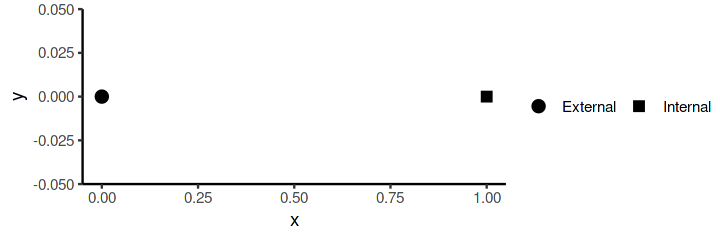

In [31]:
plot_with_legend <- ggplot(data.frame(type=c("External","Internal"), x=c(0,1)), aes(x = x, y = 0, shape = type)) +
  geom_point(size=3) +
  scale_shape_manual(values = c(19, 15)) + labs(shape="") +
  theme_classic() +
  guides(shape = guide_legend(nrow = 1)) +
  theme(legend.margin = margin(t = -5, r = 0, b = 0, l = 0, unit = "pt")) 
  
legend <- get_legend(plot_with_legend)
plot_with_legend

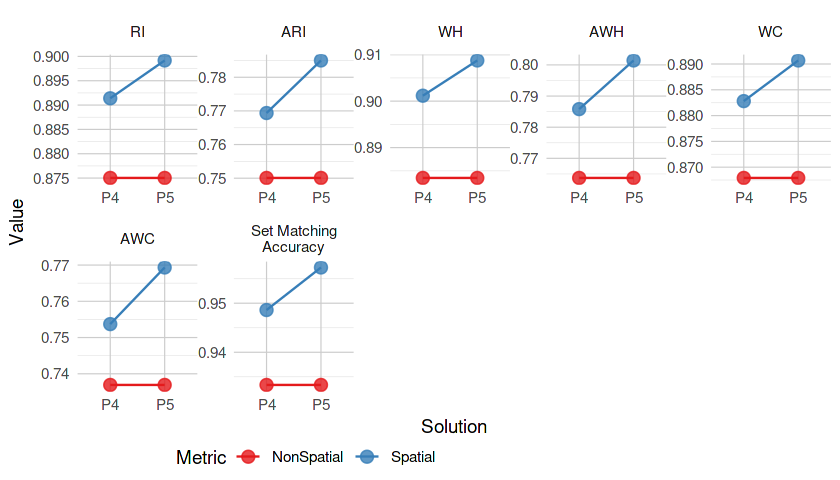

In [32]:
options(repr.plot.width=7, repr.plot.height=4)
pxx <- external %>% 
ggplot(aes(x=prediction, y=value, color=metric_type)) +
geom_point(size=3, alpha=0.8) +
geom_line(aes(group=metric)) +
facet_wrap(~metric_class, scales = "free", ncol=5) +
theme_minimal() +
theme(legend.margin = margin(t = -5, r = 0, b = 3, l = 0, unit = "pt"),
    panel.spacing.x = unit(0, "cm")) +  # Adjust the space between panels) +
theme(legend.position = "bottom", legend.justification = c(0.2, 0), legend.key.height = unit(0.3, "cm"),
    panel.grid.major = element_line(linewidth = 0.25, color = "grey80"),
    panel.grid.minor = element_line(linewidth = 0.15, color = "grey90")) +
labs(y="Value", x="Solution", color="Metric")  +
scale_color_brewer(palette = "Set1")
# ylim(0.7, 0.96)
pxx

In [33]:
px <- ggdraw() +
  draw_plot(pxx + theme(plot.margin = margin(0, 2, 2, 2))) +  # Main plot
  draw_plot(legend, x = 0.4, y = -0.18, width = 0.6, height = 0.48)  # Inset plot


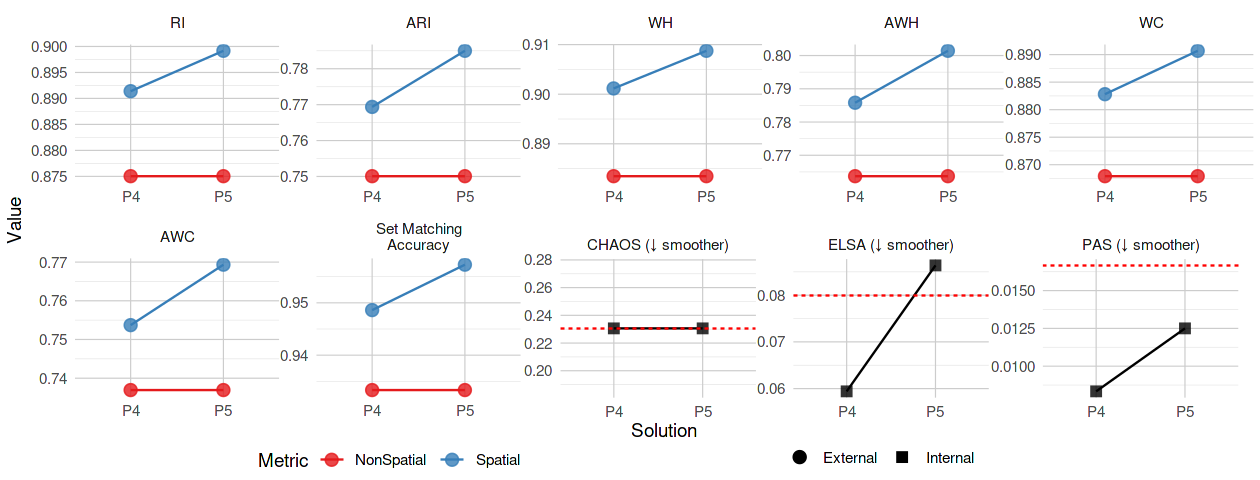

In [34]:
options(repr.plot.width=10.5, repr.plot.height=4)
p56 <- ggdraw() +
  draw_plot(px + theme(plot.margin = margin(0, 2, 2, 2))) +  # Main plot
  draw_plot(pi, x = 0.39, y = 0.059, width = 0.6, height = 0.48)  # Inset plot

p56

In [68]:
grDevices::cairo_pdf("spatial_toy_s.pdf", width=10, height=12.8)
plot_grid(ps1 + theme(legend.position = "None"), 
          p12 + theme(legend.position = "None"), 
          ps3 + theme(plot.margin = margin(0, 160, 0, 20)), 
          p56 + theme(plot.margin = margin(0, 50, 2, 50)), 
labels = c("a", "b", "c", "d"), 
label_size = 18,
ncol = 1, rel_heights = c(2.8,4,2.8,4))
dev.off()


png 
  2

In [36]:
externalSpatialClass <- do.call(rbind, lapply(setNames(pred, pred_name), function(x){as.data.frame(getSpatialClassExternalMetrics(label, data[[x]], location=location, fuzzy_true=fuzzy_true, fuzzy_pred=fuzzy_pred, k=k, metrics=c("SpatialWH","SpatialAWH", 
                                                     "SpatialWC","SpatialAWC")))}))
externalSpatialClass$prediction <- sapply(strsplit(rownames(externalSpatialClass), "\\."), function(x){x[1]})
externalSpatialClass$class <- sapply(strsplit(rownames(externalSpatialClass), "\\."), function(x){x[2]})
externalSpatialClass
dfl <- externalSpatialClass %>% pivot_longer(cols = c("SpatialWH","SpatialAWH", "SpatialWC","SpatialAWC"), names_to = "metric", values_to = "value")
dfl$metric <- factor(dfl$metric, levels=c("SpatialWH","SpatialAWH", "SpatialWC","SpatialAWC"))

Comparing between a fuzzy truth and a hard prediction...

Standard error of the mean NDC across permutations:0.000295

Comparing between a fuzzy truth and a hard prediction...

Standard error of the mean NDC across permutations:0.00118



,SpatialWH,SpatialAWH,SpatialWC,SpatialAWC,class,cluster,prediction
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>
P4.1,NA,NA,1.0000000,1.0000000,1,NA,P4
P4.2,NA,NA,0.8144880,0.6117834,2,NA,P4
P4.3,0.8025610,0.5711863,NA,NA,3,1,P4
P4.4,1.0000000,1.0000000,NA,NA,4,2,P4
P5.1,NA,NA,1.0000000,1.0000000,1,NA,P5
P5.2,NA,NA,0.8275962,0.6382043,2,NA,P5
P5.3,0.8185141,0.6062412,NA,NA,3,1,P5
P5.4,1.0000000,1.0000000,NA,NA,4,2,P5


In [37]:
df1 <- dfl %>% filter(metric %in% c("SpatialWH","SpatialAWH")) %>% select(-class) %>%  drop_na() %>% rename(class = cluster)
df2 <- dfl %>% filter(metric %in% c("SpatialWC","SpatialAWC")) %>% select(-cluster) %>%  drop_na() 
df1 <- as.data.frame(df1)
df2 <- as.data.frame(df2)
dfl <- rbind(df1,df2)
dfl$class <- factor(dfl$class, levels=c(1,2))

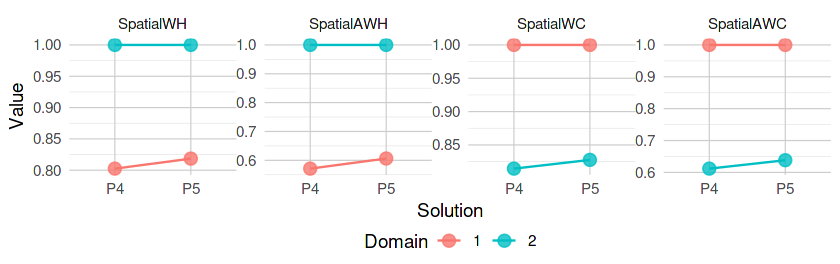

In [38]:
options(repr.plot.width=7, repr.plot.height=2.2)
pclass3 <- dfl %>% 
ggplot(aes(x=prediction, y=value, color=class)) +
geom_point(size=3, alpha=0.8) +
geom_line(aes(group=class)) +
facet_wrap(~metric, scales = "free", ncol=5) +
theme_minimal() +
theme(legend.margin = margin(t = -5, r = 0, b = 3, l = 0, unit = "pt"),
    panel.spacing.x = unit(0, "cm")) +  # Adjust the space between panels) +
theme(legend.position = "bottom", 
    # legend.justification = c(0.2, 0), 
    legend.key.height = unit(0.3, "cm"),
    panel.grid.major = element_line(linewidth = 0.25, color = "grey80"),
    panel.grid.minor = element_line(linewidth = 0.15, color = "grey90")) +
labs(y="Value", x="Solution", color="Domain") +
# scale_color_brewer(palette = "Set1") +
scale_y_continuous(breaks=scales::pretty_breaks())
# ylim(0.7, 0.96)
pclass3

In [39]:
grDevices::cairo_pdf("spatial_toy_s_class.pdf", width=6, height=3.5)
plot_grid(pclass1 + theme(legend.position = "None"), 
          pclass3,
labels = c("a", "b"), 
label_size = 18,
ncol = 1, rel_heights = c(3,3))
dev.off()

png 
  2